In [ ]:
!pip install langchain_community
!pip install replicate
from langchain_community.llms import Replicate
import os
from google.colab import userdata
import pandas as pd
import numpy as np
import os
import time
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

# Set the API token
api_token = userdata.get('REPLICATE_API_TOKEN')
os.environ["REPLICATE_API_TOKEN"] = api_token
# Model setup
model = "ibm-granite/granite-3.3-8b-instruct"
output = Replicate(
model=model,
replicate_api_token=api_token,
)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 23.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.2/45.2 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.6/48.6 kB 1.8 MB/s eta 0:00:00


#PREPROCESSING DATA

In [ ]:
folder_path = "/content/drive/MyDrive/DATASET/GAMMAFEST/Paper Database/Paper Database"
files = [f for f in os.listdir(folder_path) if f.endswith('.txt')]
data = []
for file_name in files:
    file_path = os.path.join(folder_path, file_name)
    with open(file_path, 'r', encoding='utf-8') as f:
        content = f.read().strip()
    data.append({
        "judul": os.path.splitext(file_name)[0],
        "isi": content
    })
df = pd.DataFrame(data)

In [ ]:
df1 = pd.read_csv('/content/drive/MyDrive/DATASET/GAMMAFEST/train.csv')

In [ ]:
judul_to_isi = dict(zip(df['judul'], df['isi']))
df_precln = pd.DataFrame({
    'paper': df1['paper'].map(judul_to_isi),
    'paper_id': df1['paper'],
    'referenced_paper': df1['referenced_paper'].map(judul_to_isi),
    'referenced_paper_id': df1['referenced_paper'],
    'is_referenced': df1['is_referenced']
})
df_precln.head()

,paper,paper_id,referenced_paper,referenced_paper_id,is_referenced
0,Findings of the Association for Computational ...,p2128,Optimization Methods for Large-Scale Machine L...,p3728,0
1,Residual Algorithms:\nReinforcement Learning w...,p0389,“© 2019 IEEE. Personal use of this material is...,p3811,0
2,SegNet: A Deep Convolutional Encoder-Decoder\n...,p1298,Integrative Methods for Analysing Big Data in\...,p3760,0
3,Segmentation-Aware Convolutional Networks Usin...,p0211,he goals of IBM Research are to advance comput...,p1808,0
4,Vol.:(0123456789)\nArchives of Computational M...,p0843,"Machine Learning, 22, 33-57 \nO 1996 Kluwer Ac...",p2964,0


#MODELING USING IBM GRANITE 3.3 8B INSTRUCT

In [ ]:
df_ex = (
    df_precln
    .groupby("is_referenced", group_keys=False)
    .apply(lambda x: x.sample(n=1, random_state=42))
)
df_ex.head()

/tmp/ipython-input-2661511708.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(n=1, random_state=42))


,paper,paper_id,referenced_paper,referenced_paper_id,is_referenced
339300,Accelerating the Super-Resolution\nConvolution...,p2246,Web-Scale Training for Face Identiﬁcation\nYan...,p0808,0
339528,ViViT: A Video Vision Transformer\nAnurag Arna...,p4225,Published as a conference paper at ICLR 2018\n...,p0160,1


In [ ]:
df_cln = (
    df_precln[df_precln["is_referenced"] == 1]
      .sample(n=1, random_state=1)
)
df_ans = df_cln["is_referenced"]
df_ans = df_cln["is_referenced"].rename("citation_true")
df_cln = df_cln.drop("is_referenced", axis=1)
df_cln.head()

,paper,paper_id,referenced_paper,referenced_paper_id
237922,Pyramid Vision Transformer: A Versatile Backbo...,p3178,Squeeze-and-Excitation Networks\nJie Hu[0000−0...,p1129


In [ ]:
parameters = {
    "top_k": 1,
    "top_p": 1.0,
    "max_tokens": 1,
    "min_tokens": 1,
    "random_seed": 42,
    "repetition_penalty": 1.2,
    "stopping_criteria": "sequence",
    "stopping_sequence": ["\n"]
}

def predict_citation(paper_text, ref_text, df_ex):
    example_pos = df_ex.iloc[0]
    example_neg = df_ex.iloc[1]
    prompt = f"""
    Task: Determine if the paper_task cites the referenced_paper_task.
    Definition: "Cite" means the paper includes the referenced paper in its bibliography or reference list.
    It is not enough to just mention similar topics; the referenced paper must appear as a formal citation.

    Output rules:
    - Return only '1' if cited.
    - Return only '0' if not cited.
    - Do not write anything else (no words, no explanation, no sentences).
    - The answer must be exactly one character: '1' or '0'.

    Example:
    Paper: {example_pos['paper']}
    Referenced Paper: {example_pos['referenced_paper']}
    Answer: paper cites referenced_paper

    Example:
    Paper: {example_neg['paper']}
    Referenced Paper: {example_neg['referenced_paper']}
    Answer: paper does not cites referenced_paper

    paper_task: {paper_text}
    referenced_paper_task: {ref_text}
    Final Answer (strictly '1' or '0' only):
    """
    response = output.invoke(prompt, parameters=parameters)
    response = response.strip().replace("'", "").replace('"', "")
    print("RAW:", response)

    if response.startswith("1"):
        return "1"
    elif response.startswith("0"):
        return "0"
    else:
        return "0"

df_cln["citation_pred"] = df_cln.apply(
    lambda row: predict_citation(row["paper"], row["referenced_paper"], df_ex),
    axis=1
)

df_cln_pred = df_cln["citation_pred"]

RAW: 0


In [ ]:
df_cln_pred.head(), df_ans.head()

(237922    0
 Name: citation_pred, dtype: object,
 237922    1
 Name: citation_true, dtype: int64)

#METRIK EVALUASI

Hasil prediksi sitasi menggunakan IBM Granite 3.3 8b Instruct

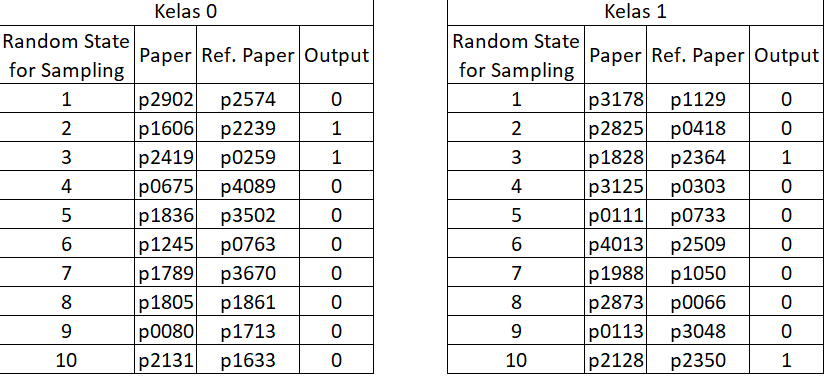

In [ ]:
y_pred = [0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1]
y_true = [0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1]

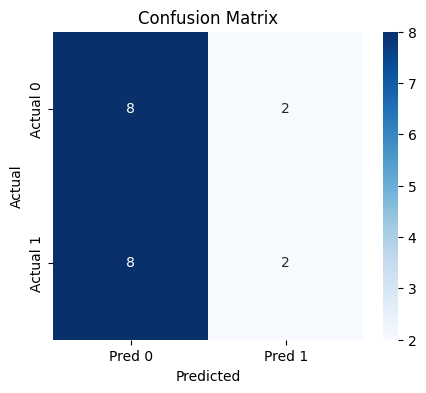

In [ ]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Pred 0","Pred 1"], yticklabels=["Actual 0","Actual 1"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
print("Accuracy :", accuracy_score(y_true, y_pred))
print("Precision:", precision_score(y_true, y_pred))
print("Recall   :", recall_score(y_true, y_pred))
print("F1-score :", f1_score(y_true, y_pred))
print("\nClassification Report:\n", classification_report(y_true, y_pred))

Accuracy : 0.5
Precision: 0.5
Recall   : 0.2
F1-score : 0.2857142857142857

Classification Report:
               precision    recall  f1-score   support

           0       0.50      0.80      0.62        10
           1       0.50      0.20      0.29        10

    accuracy                           0.50        20
   macro avg       0.50      0.50      0.45        20
weighted avg       0.50      0.50      0.45        20

